# KAIST Summer Session 2018

## Reply Bot_v1 based on Recurrent Neural Network (08.23.2018)


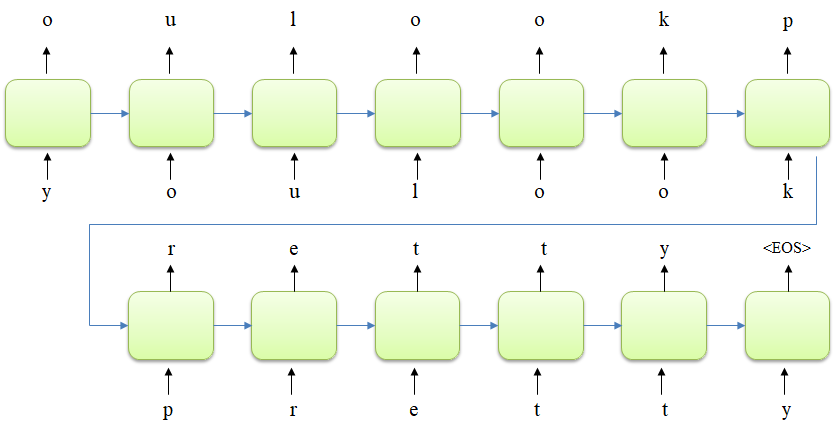

### 0. Data Preparation

In [61]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time

chars = "abcdefghijklmnopqrstuvwxyz ?!.,:;"
char_list = [i for i in chars]
char_len = len(char_list)

num_layers = 2
input_size = char_len
hidden_size = char_len 
learning_rate = 0.001
num_epochs = 1000

- One-hot (sparse) representation
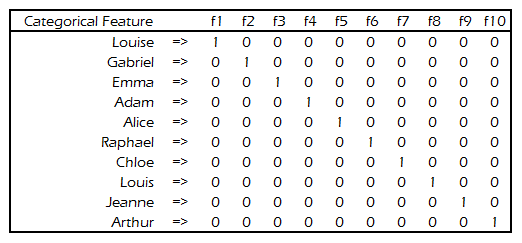

In [62]:
# String to onehot vector# Strin 
# a -> [1 0 0 ... 0 0]

def string_to_onehot(string):
    start = np.zeros(shape=len(char_list) ,dtype=int)
    for i in string:
        idx = char_list.index(i)
        zero = np.zeros(shape=char_len ,dtype=int)
        zero[idx]=1
        start = np.vstack([start,zero])
    return start

# Onehot vector to word
# [1 0 0 ... 0 0] -> a 

def onehot_to_word(onehot_1):
    onehot = torch.Tensor.numpy(onehot_1)
    if onehot.max()==0:
        return ''
    else:
        return char_list[onehot.argmax()]

In [63]:
string_1  =  "hello you are pretty"
string_one_hot_1 = torch.from_numpy(string_to_onehot(string_1)).type_as(torch.FloatTensor())

string_2  =  "the man should be wrong"
string_one_hot_2 = torch.from_numpy(string_to_onehot(string_2)).type_as(torch.FloatTensor())

unroll_len_1 = string_one_hot_1.size()[0] - 1
unroll_len_2 = string_one_hot_2.size()[0] - 1

### 1. Define a Neural Network
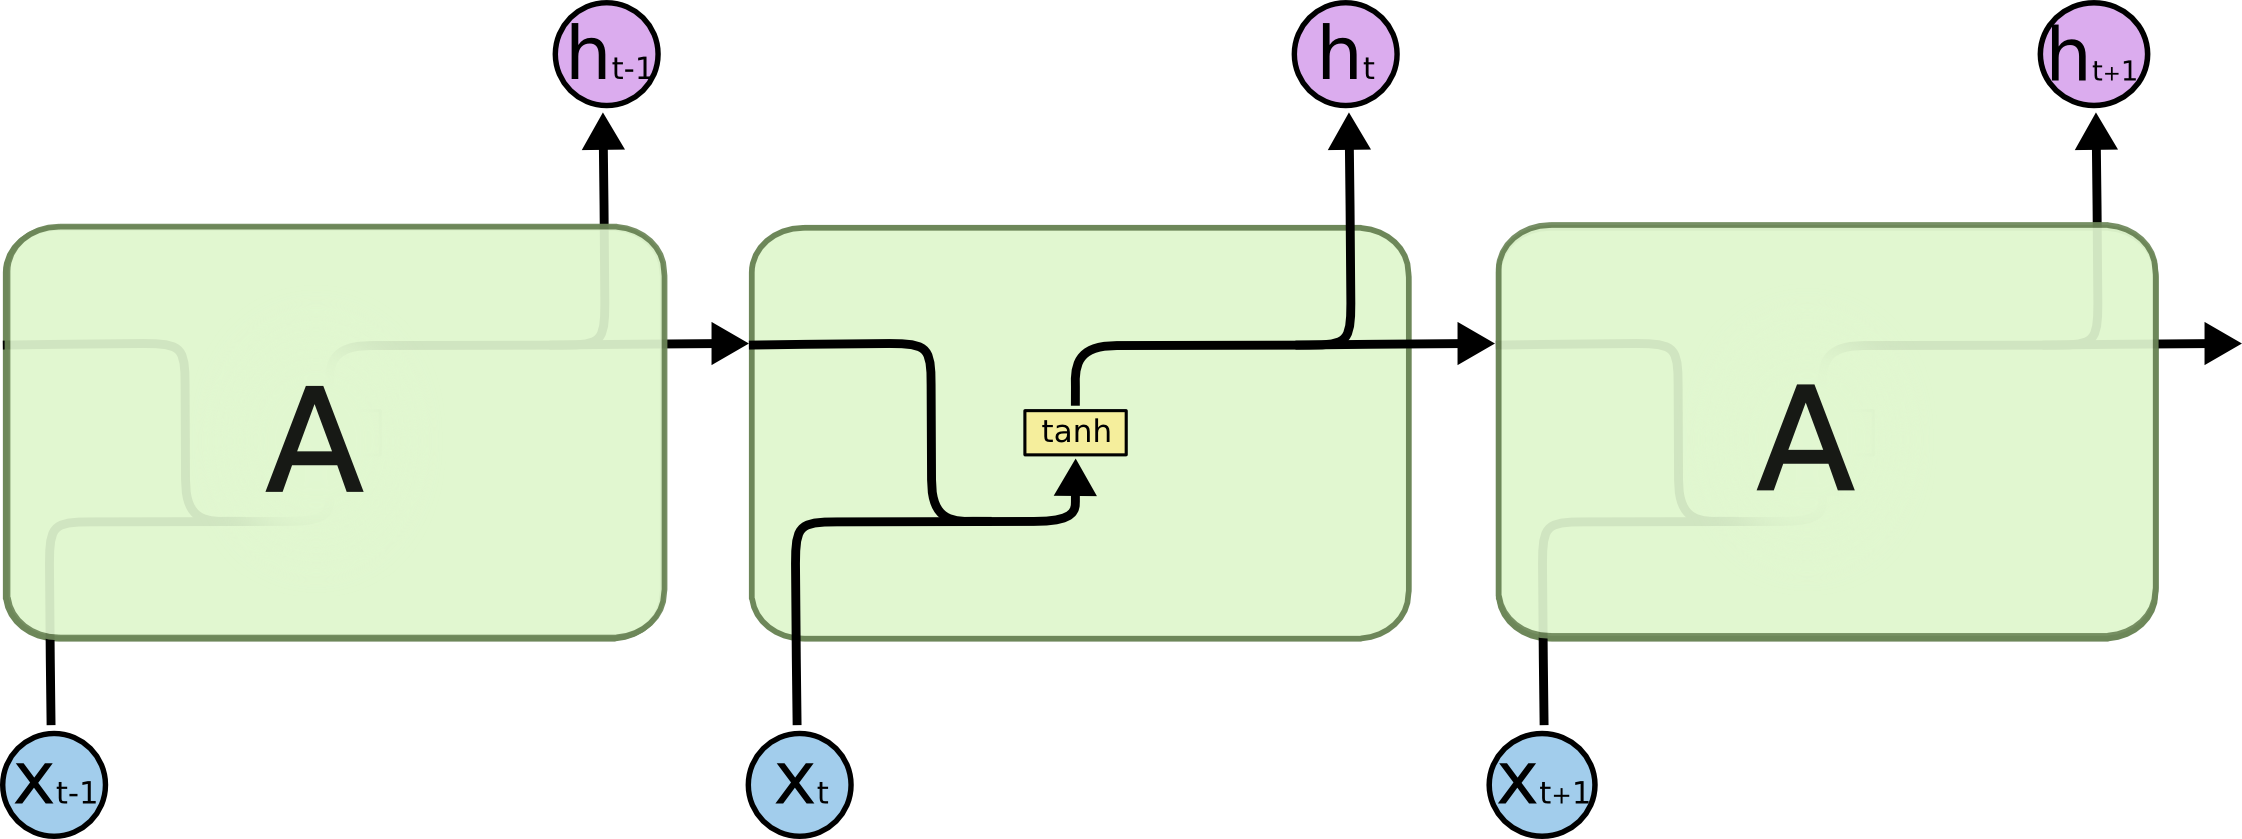

In [64]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers)
        
    def forward(self,input, hidden):
        output, hidden = self.rnn(input, hidden)        
        return output,hidden
    
    def init_hidden(self):
        hidden = torch.zeros(self.num_layers, 1, self.hidden_size)        
        return hidden

### 2. Define a Loss Function and Optimizer

In [65]:
# Instantiate RNN model
rnn = RNN(input_size, hidden_size, num_layers)

# Set loss and optimizer function
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

### 3. Training and Evaluation

In [66]:
start = time.time()

for i in range(num_epochs):

    loss = 0
    
    hidden = rnn.init_hidden()
    for j in range(1, unroll_len_1):
        input_data = torch.tensor(string_one_hot_1[j:j+1].view(1,1,-1))
        label = torch.tensor(string_one_hot_1[j+1:j+2].view(1,1,-1))
        output, hidden = rnn(input_data, hidden)
        loss += criterion(output.view(1,-1),label.view(1,-1))
    
    hidden = rnn.init_hidden()
    for j in range(1, unroll_len_2):
        input_data = torch.tensor(string_one_hot_2[j:j+1].view(1,1,-1))
        label = torch.tensor(string_one_hot_2[j+1:j+2].view(1,1,-1))
        output, hidden = rnn(input_data, hidden)
        loss += criterion(output.view(1,-1),label.view(1,-1))
        
    if i % 100 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(i, loss.data))
    
    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()

now = time.time()
print("Learning finished! It takes {:.0f} seconds".format(now-start))

Train Epoch: 0	Loss: 3.283503
Train Epoch: 100	Loss: 0.747487
Train Epoch: 200	Loss: 0.419151
Train Epoch: 300	Loss: 0.255716
Train Epoch: 400	Loss: 0.168521
Train Epoch: 500	Loss: 0.122663
Train Epoch: 600	Loss: 0.093096
Train Epoch: 700	Loss: 0.075024
Train Epoch: 800	Loss: 0.062610
Train Epoch: 900	Loss: 0.053526
Learning finished! It takes 26 seconds


- Let's see how the model works well

In [67]:
string_test  = "h"

string_test_one_hot = torch.from_numpy(string_to_onehot(string_test)).type_as(torch.FloatTensor())
input_data = torch.tensor(string_test_one_hot[1].view(1,1,-1))

hidden = rnn.init_hidden()

print(onehot_to_word(input_data),end="")

for j in range(unroll_len_1-1):
    output, hidden = rnn(input_data, hidden)
    input_data = output.data
    print(onehot_to_word(output.data),end="")

hello y uhon  hetlo 

In [68]:
string_test  = "t"

string_test_one_hot = torch.from_numpy(string_to_onehot(string_test)).type_as(torch.FloatTensor())
input_data = torch.tensor(string_test_one_hot[1].view(1,1,-1))

hidden = rnn.init_hidden()

print(onehot_to_word(input_data),end="")

for j in range(unroll_len_2-1):
    output, hidden = rnn(input_data, hidden)
    input_data = output.data
    print(onehot_to_word(output.data),end="")

the man shoulro  rhrt  

### 4. Using Gated Recurrent Unit (GRU) instead of Basic RNN
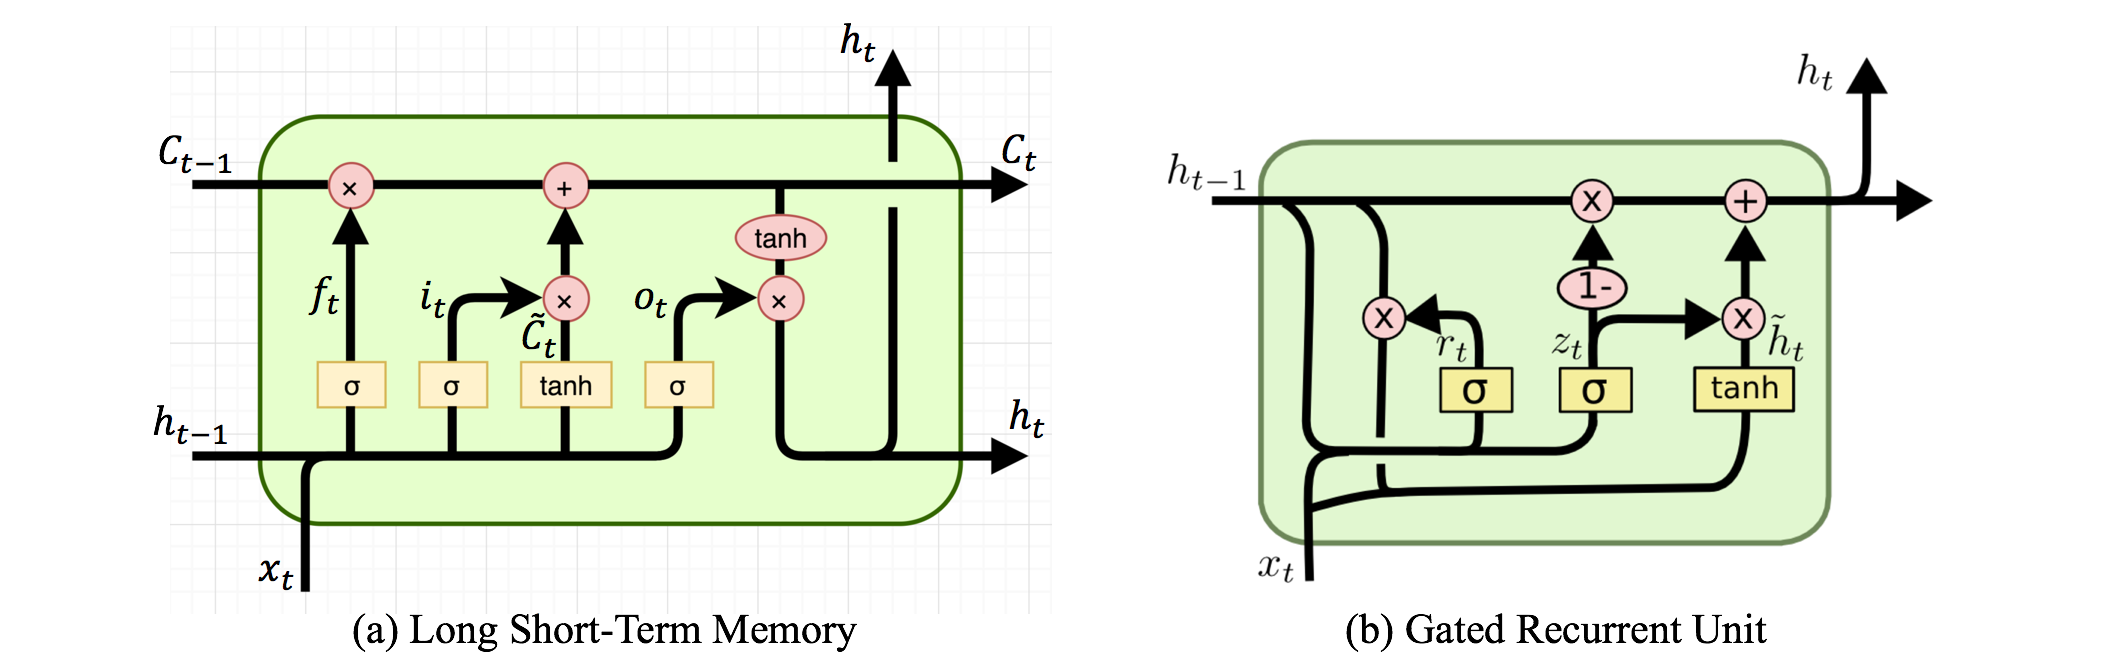

In [69]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        
    def forward(self,input,hidden):
        output, hidden = self.gru(input,hidden)        
        return output,hidden
    
    def init_hidden(self):
        hidden = torch.zeros(self.num_layers, 1, self.hidden_size)        
        return hidden

In [70]:
gru = GRU(input_size, hidden_size, num_layers)

criterion = nn.MSELoss()
optimizer = optim.Adam(gru.parameters(), lr=learning_rate)

In [71]:
start = time.time()

for i in range(num_epochs):
        
    loss = 0
    
    hidden = gru.init_hidden()
    for j in range(1, unroll_len_1):
        input_data = torch.tensor(string_one_hot_1[j:j+1].view(1,1,-1))
        label = torch.tensor(string_one_hot_1[j+1:j+1+1].view(1,1,-1))
        output, hidden = gru(input_data, hidden)
        loss += criterion(output.view(1,-1),label.view(1,-1))
    
    hidden = gru.init_hidden()
    for j in range(1, unroll_len_2):
        input_data = torch.tensor(string_one_hot_2[j:j+1].view(1,1,-1))
        label = torch.tensor(string_one_hot_2[j+1:j+2].view(1,1,-1))
        output, hidden = gru(input_data, hidden)
        loss += criterion(output.view(1,-1),label.view(1,-1))
        
    if i % 100 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(i, loss.data))
    
    optimizer.zero_grad() 
    loss.backward()
    optimizer.step()

now = time.time()
print("Learning finished! It takes {:.0f} seconds".format(now-start))

Train Epoch: 0	Loss: 1.822636
Train Epoch: 100	Loss: 0.964038
Train Epoch: 200	Loss: 0.524414
Train Epoch: 300	Loss: 0.254780
Train Epoch: 400	Loss: 0.109873
Train Epoch: 500	Loss: 0.043736
Train Epoch: 600	Loss: 0.019408
Train Epoch: 700	Loss: 0.010276
Train Epoch: 800	Loss: 0.006253
Train Epoch: 900	Loss: 0.004205
Learning finished! It takes 42 seconds


In [72]:
string_test  = "h"

string_test_one_hot = torch.from_numpy(string_to_onehot(string_test)).type_as(torch.FloatTensor())
input_data = torch.tensor(string_test_one_hot[1].view(1,1,-1))

hidden = gru.init_hidden()

print(onehot_to_word(input_data),end="")

for j in range(unroll_len_1-1):
    output, hidden = gru(input_data, hidden)
    input_data = output.data
    print(onehot_to_word(output.data),end="")

hello you are pretty

In [73]:
string_test  = "t"

string_test_one_hot = torch.from_numpy(string_to_onehot(string_test)).type_as(torch.FloatTensor())
input_data = torch.tensor(string_test_one_hot[1].view(1,1,-1))

hidden = gru.init_hidden()

print(onehot_to_word(input_data),end="")

for j in range(unroll_len_2-1):
    output, hidden = gru(input_data, hidden)
    input_data = output.data
    print(onehot_to_word(output.data),end="")

the man should be wrong

### 5. Using Long Short-Term Memory (LSTM) instead of Basic RNN
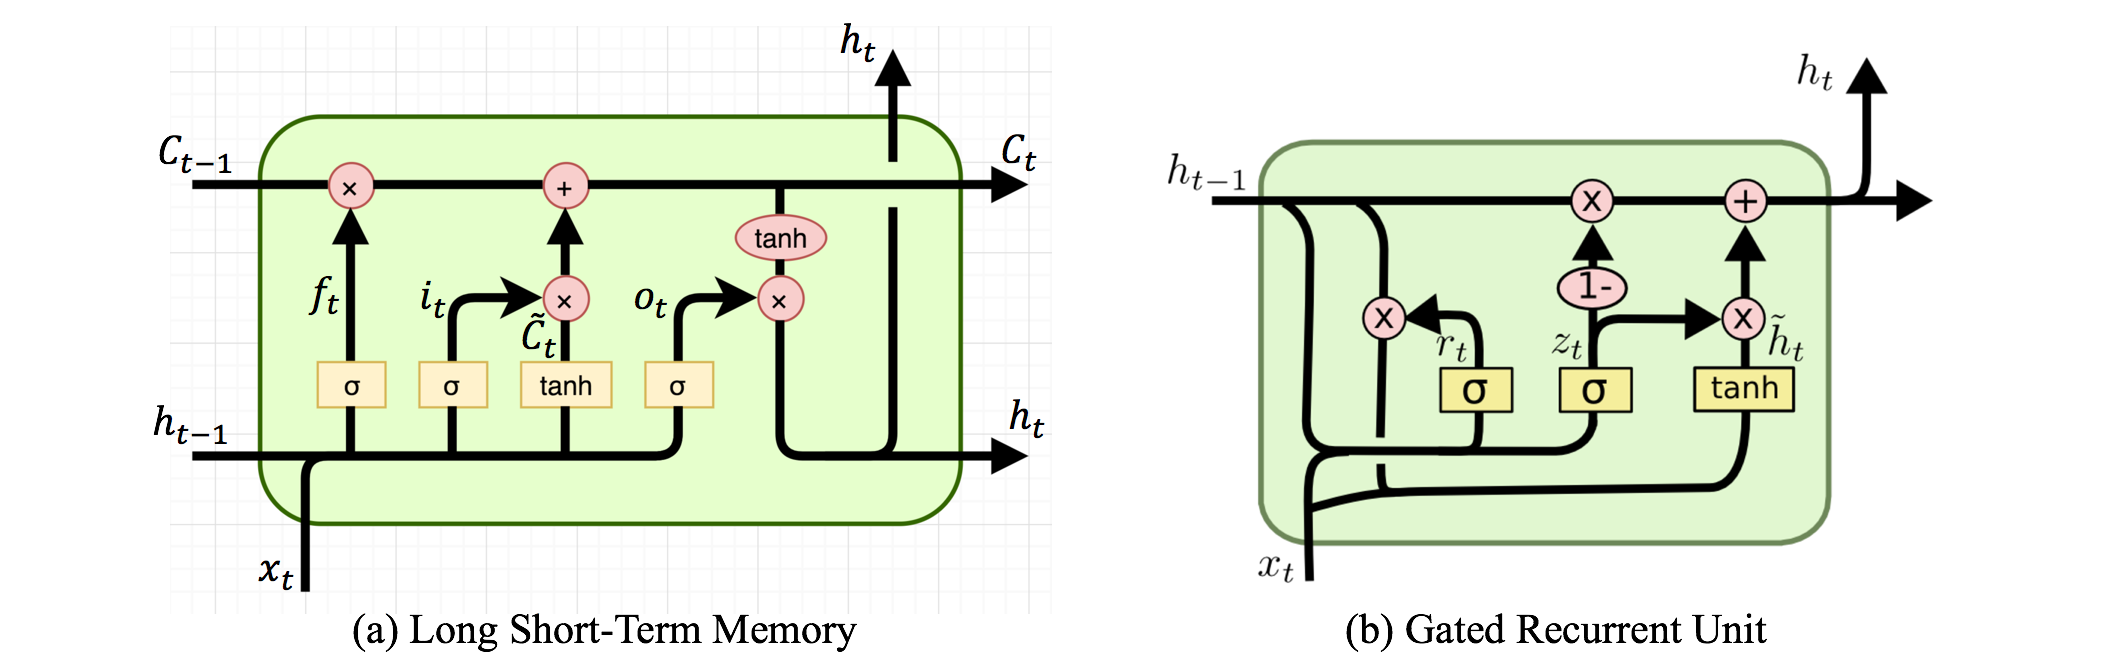

In [74]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        
    def forward(self,input,hidden,cell):
        output,(hidden, cell) = self.lstm(input,(hidden, cell))        
        return output,hidden, cell

    
    def init_hidden_cell(self):
        hidden = torch.zeros(self.num_layers, 1, self.hidden_size)
        cell = torch.zeros(self.num_layers, 1, self.hidden_size)        
        return hidden,cell  

In [75]:
lstm = LSTM(input_size, hidden_size, num_layers)

criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)

In [76]:
start = time.time()

for i in range(num_epochs):
    
    loss = 0
    
    hidden, cell = lstm.init_hidden_cell()
    for j in range(1, unroll_len_1):
        input_data = torch.tensor(string_one_hot_1[j:j+1].view(1,1,-1))
        label = torch.tensor(string_one_hot_1[j+1:j+2].view(1,1,-1))
        output, hidden, cell = lstm(input_data, hidden, cell)
        loss += criterion(output.view(1,-1),label.view(1,-1))
    
    hidden, cell = lstm.init_hidden_cell()
    for j in range(1, unroll_len_2):
        input_data = torch.tensor(string_one_hot_2[j:j+1].view(1,1,-1))
        label = torch.tensor(string_one_hot_2[j+1:j+2].view(1,1,-1))
        output, hidden, cell = lstm(input_data, hidden, cell)
        loss += criterion(output.view(1,-1),label.view(1,-1))
        
    if i % 100 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(i, loss.data))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

now = time.time()
print("Learning finished! It takes {:.0f} seconds".format(now-start))

Train Epoch: 0	Loss: 1.427972
Train Epoch: 100	Loss: 0.972771
Train Epoch: 200	Loss: 0.619196
Train Epoch: 300	Loss: 0.363185
Train Epoch: 400	Loss: 0.216593
Train Epoch: 500	Loss: 0.135300
Train Epoch: 600	Loss: 0.093372
Train Epoch: 700	Loss: 0.071110
Train Epoch: 800	Loss: 0.057514
Train Epoch: 900	Loss: 0.047991
Learning finished! It takes 43 seconds


In [77]:
string_test  = "h"

string_test_one_hot = torch.from_numpy(string_to_onehot(string_test)).type_as(torch.FloatTensor())
input_data = torch.tensor(string_test_one_hot[1].view(1,1,-1))

hidden, cell = lstm.init_hidden_cell()

print(onehot_to_word(input_data),end="")

for j in range(unroll_len_1-1):
    output, hidden, cell = lstm(input_data, hidden, cell)
    input_data = output.data
    print(onehot_to_word(output.data),end="")

hello you are prettg

In [78]:
string_test  = "t"

string_test_one_hot = torch.from_numpy(string_to_onehot(string_test)).type_as(torch.FloatTensor())
input_data = torch.tensor(string_test_one_hot[1].view(1,1,-1))

hidden, cell = lstm.init_hidden_cell()

print(onehot_to_word(input_data),end="")

for j in range(unroll_len_2-1):
    output, hidden, cell = lstm(input_data, hidden, cell)
    input_data = output.data
    print(onehot_to_word(output.data),end="")

the man shoould be wron